In [50]:
import sys
import random
import glob
sys.path.append("../")
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import os
import pandas as pd
from torch.optim import AdamW
from utils.custom_scheduler import CustomCosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

os.chdir("/home/dhai/coding/brain_project")
print("현재 작업 디렉토리:", os.getcwd())

# 상위 폴더로 이동한 경로로 파일 불러오기
df = pd.read_csv("./dataloader.csv")

# split 기준으로 나누기
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

# 확인
print(f"✅ train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

현재 작업 디렉토리: /home/dhai/coding/brain_project
✅ train: 505, val: 159, test: 195


In [51]:
class FMRIDataset(Dataset):
    def __init__(self, df, label_map):
        self.stories = []
        self.label_map = label_map

        for _, row in df.iterrows():
            fmri_path = row["run_path"]
            label = self.label_map[row["ground_truth"]]
            age = float(row["age"])  # adition infomation age

            text_dirs = [p.strip() for p in row["text_path"].split(",")]
            text_counts = [int(n) for n in str(row["text_frame"]).split(",")]
            fmri_files = sorted(
                glob.glob(os.path.join(fmri_path, "frame_*.pt")),
                key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[1])
            )
            assert len(fmri_files) == sum(text_counts), f"{fmri_path}: 파일 수 불일치"
            text_files_all = []
            for dir_path, count in zip(text_dirs, text_counts):
                # text_block_1.pt ~ text_block_count.pt
                text_files = sorted(
                    glob.glob(os.path.join(dir_path, "text_block_*.pt")),
                    key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[2])
                )
                # 만약 text_block_1.pt부터 시작이라면 text_files[:count]로 매칭
                text_files_all.extend(text_files[:count])

            # fmri와 text feature를 1:1로 매칭
            assert len(fmri_files) == len(text_files_all), f"{fmri_path}: 파일 수 불일치 fmri:{len(fmri_files)} text:{len(text_files_all)}"
            self.stories.append({
                "fmri_feats": fmri_files,
                "text_feats": text_files_all,
                "label": label,
                "age": age
            })

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        story = self.stories[idx]
        fmri_feats = torch.stack([torch.load(f).float() for f in story["fmri_feats"]])  # [num_frames, fmri_dim]
        text_feats = torch.stack([torch.load(f).float() for f in story["text_feats"]])  # [num_frames, text_dim]
        age_tensor = torch.tensor([story["age"]]).float()
        age_feats = age_tensor.expand(text_feats.size(0), 1)  # [num_frames, 1]
        text_feats = torch.cat([text_feats, age_feats], dim=1)  # [num_frames, text_dim+1]
        label = story["label"]
        return fmri_feats, text_feats, label

In [52]:
class Text_Or_FMRI_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()

        self.class_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # <-- 입력 차원 바뀜
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, fmri_feats):
        pooled_fmri = fmri_feats.mean(dim=1)
        # pooled_text = text_feats.mean(dim=1)
        class_out = self.class_head(pooled_fmri)
        return class_out

In [56]:
def train_epoch(dataloader, model, optimizer, scaler=None, writer=None, epoch=0, alpha=5.0):
    model.train()
    total_loss = 0

    loss_cls = nn.CrossEntropyLoss()
    for i, (fmri, text, label) in enumerate(dataloader):
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                pred_label = model(fmri)  # [1, num_frames, fmri_dim]
                cls_loss = loss_cls(pred_label, label)
                loss = cls_loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred_label = model(text)
            cls_loss = loss_cls(pred_label, label)
            loss = cls_loss          
            loss.backward()
            optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)

    if writer:
        writer.add_scalar('LearningRate/Train_lr', optimizer.param_groups[0]['lr'], epoch)     
        writer.add_scalar('Train/TotalLoss', avg_loss, epoch)

    return avg_loss

def validate_epoch_pretrain(dataloader, model, epoch, writer=None):
    model.eval()
    total_loss = 0

    loss_cls = nn.CrossEntropyLoss()
    with torch.no_grad():
        for fmri, text, label in dataloader:
            fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
            pred_label = model(fmri)
            cls_loss = loss_cls(pred_label, label)
            loss = cls_loss
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)

    if writer:
        writer.add_scalar('Val/TotalLoss', avg_loss, epoch)

    return avg_loss


In [57]:
label_map = {"all": 0, "15": 1, "19": 2}
batch_sizes = 1
train_dataset = FMRIDataset(train_df, label_map)
val_dataset   = FMRIDataset(val_df, label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_sizes)

In [63]:
model = Text_Or_FMRI_Classifier(input_dim=288, hidden_dim=512, num_classes=3).cuda()
optimizer = AdamW(model.parameters(), lr=0.000005, weight_decay=0.05, betas=(0.9, 0.999))
scheduler = CustomCosineAnnealingWarmRestarts(optimizer=optimizer, T_0=50, T_mult=2, eta_min=0, eta_max=0.000005, decay_factor=0.9, start_epoch=0)
epochs = 50
scaler = GradScaler()
writer = SummaryWriter(log_dir="./tensorboard/experiment_only_fmri_2")
best_val_loss = float('inf')

for epoch in trange(epochs):
    train_loss = train_epoch(train_loader, model, optimizer, scaler, writer, epoch)
    val_loss = validate_epoch_pretrain(val_loader, model, epoch, writer)
    scheduler.step(epoch)
    print(f"[{epoch+1}/{epochs}] TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}")

    # Best 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "./experiments/experiment_only_fmri_2_best_model.pth")
        print("save best model")

writer.close()

/tmp/ipykernel_4019/1268182352.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[5e-06]


/tmp/ipykernel_4019/3819376551.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  2%|▉                                           | 1/50 [00:03<02:51,  3.50s/it]

[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[5e-06]
[1/50] TrainLoss: 1.0545  ValLoss: 1.3344
save best model


  4%|█▊                                          | 2/50 [00:07<02:48,  3.51s/it]

[DEBUG step] epoch=1, effective_epoch=1, T_cur=1, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=1, T_cur=1, current_cycle=0, _last_lr=[4.9950668210706795e-06]
[2/50] TrainLoss: 1.0090  ValLoss: 1.4275


  6%|██▋                                         | 3/50 [00:10<02:46,  3.53s/it]

[DEBUG step] epoch=2, effective_epoch=2, T_cur=2, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=2, T_cur=2, current_cycle=0, _last_lr=[4.980286753286196e-06]
[3/50] TrainLoss: 0.9787  ValLoss: 1.5064


  8%|███▌                                        | 4/50 [00:14<02:41,  3.51s/it]

[DEBUG step] epoch=3, effective_epoch=3, T_cur=3, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=3, T_cur=3, current_cycle=0, _last_lr=[4.9557181268217225e-06]
[4/50] TrainLoss: 0.9584  ValLoss: 1.5950


 10%|████▍                                       | 5/50 [00:17<02:37,  3.49s/it]

[DEBUG step] epoch=4, effective_epoch=4, T_cur=4, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=4, T_cur=4, current_cycle=0, _last_lr=[4.921457902821578e-06]
[5/50] TrainLoss: 0.9423  ValLoss: 1.6576


 12%|█████▎                                      | 6/50 [00:20<02:33,  3.49s/it]

[DEBUG step] epoch=5, effective_epoch=5, T_cur=5, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=5, T_cur=5, current_cycle=0, _last_lr=[4.8776412907378845e-06]
[6/50] TrainLoss: 0.9301  ValLoss: 1.6888


 14%|██████▏                                     | 7/50 [00:24<02:29,  3.48s/it]

[DEBUG step] epoch=6, effective_epoch=6, T_cur=6, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=6, T_cur=6, current_cycle=0, _last_lr=[4.824441214720629e-06]
[7/50] TrainLoss: 0.9205  ValLoss: 1.7452


 16%|███████                                     | 8/50 [00:27<02:26,  3.48s/it]

[DEBUG step] epoch=7, effective_epoch=7, T_cur=7, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=7, T_cur=7, current_cycle=0, _last_lr=[4.762067631165049e-06]
[8/50] TrainLoss: 0.9115  ValLoss: 1.7883


 18%|███████▉                                    | 9/50 [00:31<02:22,  3.48s/it]

[DEBUG step] epoch=8, effective_epoch=8, T_cur=8, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=8, T_cur=8, current_cycle=0, _last_lr=[4.690766700109659e-06]
[9/50] TrainLoss: 0.9037  ValLoss: 1.8368


 20%|████████▌                                  | 10/50 [00:34<02:19,  3.49s/it]

[DEBUG step] epoch=9, effective_epoch=9, T_cur=9, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=9, T_cur=9, current_cycle=0, _last_lr=[4.610819813755038e-06]
[10/50] TrainLoss: 0.8964  ValLoss: 1.8580


 22%|█████████▍                                 | 11/50 [00:38<02:16,  3.49s/it]

[DEBUG step] epoch=10, effective_epoch=10, T_cur=10, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=10, T_cur=10, current_cycle=0, _last_lr=[4.522542485937369e-06]
[11/50] TrainLoss: 0.8905  ValLoss: 1.8986


 24%|██████████▎                                | 12/50 [00:41<02:13,  3.51s/it]

[DEBUG step] epoch=11, effective_epoch=11, T_cur=11, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=11, T_cur=11, current_cycle=0, _last_lr=[4.426283106939474e-06]
[12/50] TrainLoss: 0.8842  ValLoss: 1.9261


 26%|███████████▏                               | 13/50 [00:45<02:10,  3.52s/it]

[DEBUG step] epoch=12, effective_epoch=12, T_cur=12, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=12, T_cur=12, current_cycle=0, _last_lr=[4.322421568553529e-06]
[13/50] TrainLoss: 0.8785  ValLoss: 1.9562


 28%|████████████                               | 14/50 [00:49<02:06,  3.53s/it]

[DEBUG step] epoch=13, effective_epoch=13, T_cur=13, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=13, T_cur=13, current_cycle=0, _last_lr=[4.211367764821722e-06]
[14/50] TrainLoss: 0.8729  ValLoss: 1.9975


 30%|████████████▉                              | 15/50 [00:52<02:03,  3.53s/it]

[DEBUG step] epoch=14, effective_epoch=14, T_cur=14, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=14, T_cur=14, current_cycle=0, _last_lr=[4.093559974371725e-06]
[15/50] TrainLoss: 0.8685  ValLoss: 2.0182


 32%|█████████████▊                             | 16/50 [00:56<01:59,  3.51s/it]

[DEBUG step] epoch=15, effective_epoch=15, T_cur=15, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=15, T_cur=15, current_cycle=0, _last_lr=[3.969463130731184e-06]
[16/50] TrainLoss: 0.8639  ValLoss: 2.0313


 34%|██████████████▌                            | 17/50 [00:59<01:56,  3.53s/it]

[DEBUG step] epoch=16, effective_epoch=16, T_cur=16, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=16, T_cur=16, current_cycle=0, _last_lr=[3.839566987447492e-06]
[17/50] TrainLoss: 0.8592  ValLoss: 2.0795


 36%|███████████████▍                           | 18/50 [01:03<01:52,  3.51s/it]

[DEBUG step] epoch=17, effective_epoch=17, T_cur=17, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=17, T_cur=17, current_cycle=0, _last_lr=[3.7043841852542884e-06]
[18/50] TrainLoss: 0.8554  ValLoss: 2.1025


 38%|████████████████▎                          | 19/50 [01:06<01:48,  3.50s/it]

[DEBUG step] epoch=18, effective_epoch=18, T_cur=18, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=18, T_cur=18, current_cycle=0, _last_lr=[3.564448228912682e-06]
[19/50] TrainLoss: 0.8516  ValLoss: 2.1119


 40%|█████████████████▏                         | 20/50 [01:10<01:44,  3.49s/it]

[DEBUG step] epoch=19, effective_epoch=19, T_cur=19, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=19, T_cur=19, current_cycle=0, _last_lr=[3.4203113817116955e-06]
[20/50] TrainLoss: 0.8479  ValLoss: 2.1289


 42%|██████████████████                         | 21/50 [01:13<01:41,  3.50s/it]

[DEBUG step] epoch=20, effective_epoch=20, T_cur=20, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=20, T_cur=20, current_cycle=0, _last_lr=[3.272542485937369e-06]
[21/50] TrainLoss: 0.8445  ValLoss: 2.1282


 44%|██████████████████▉                        | 22/50 [01:17<01:37,  3.49s/it]

[DEBUG step] epoch=21, effective_epoch=21, T_cur=21, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=21, T_cur=21, current_cycle=0, _last_lr=[3.1217247179121366e-06]
[22/50] TrainLoss: 0.8414  ValLoss: 2.1652


 46%|███████████████████▊                       | 23/50 [01:20<01:33,  3.48s/it]

[DEBUG step] epoch=22, effective_epoch=22, T_cur=22, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=22, T_cur=22, current_cycle=0, _last_lr=[2.9684532864643123e-06]
[23/50] TrainLoss: 0.8386  ValLoss: 2.1872


 48%|████████████████████▋                      | 24/50 [01:23<01:30,  3.47s/it]

[DEBUG step] epoch=23, effective_epoch=23, T_cur=23, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=23, T_cur=23, current_cycle=0, _last_lr=[2.8133330839107612e-06]
[24/50] TrainLoss: 0.8359  ValLoss: 2.1980


 50%|█████████████████████▌                     | 25/50 [01:27<01:26,  3.47s/it]

[DEBUG step] epoch=24, effective_epoch=24, T_cur=24, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=24, T_cur=24, current_cycle=0, _last_lr=[2.6569762988232838e-06]
[25/50] TrainLoss: 0.8332  ValLoss: 2.2132


 52%|██████████████████████▎                    | 26/50 [01:30<01:23,  3.48s/it]

[DEBUG step] epoch=25, effective_epoch=25, T_cur=25, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=25, T_cur=25, current_cycle=0, _last_lr=[2.5e-06]
[26/50] TrainLoss: 0.8307  ValLoss: 2.2271


 54%|███████████████████████▏                   | 27/50 [01:34<01:20,  3.48s/it]

[DEBUG step] epoch=26, effective_epoch=26, T_cur=26, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=26, T_cur=26, current_cycle=0, _last_lr=[2.3430237011767166e-06]
[27/50] TrainLoss: 0.8286  ValLoss: 2.2410


 56%|████████████████████████                   | 28/50 [01:37<01:16,  3.48s/it]

[DEBUG step] epoch=27, effective_epoch=27, T_cur=27, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=27, T_cur=27, current_cycle=0, _last_lr=[2.18666691608924e-06]
[28/50] TrainLoss: 0.8264  ValLoss: 2.2555


 58%|████████████████████████▉                  | 29/50 [01:41<01:12,  3.47s/it]

[DEBUG step] epoch=28, effective_epoch=28, T_cur=28, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=28, T_cur=28, current_cycle=0, _last_lr=[2.0315467135356885e-06]
[29/50] TrainLoss: 0.8247  ValLoss: 2.2613


 60%|█████████████████████████▊                 | 30/50 [01:44<01:09,  3.47s/it]

[DEBUG step] epoch=29, effective_epoch=29, T_cur=29, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=29, T_cur=29, current_cycle=0, _last_lr=[1.878275282087863e-06]
[30/50] TrainLoss: 0.8230  ValLoss: 2.2714


 62%|██████████████████████████▋                | 31/50 [01:48<01:06,  3.49s/it]

[DEBUG step] epoch=30, effective_epoch=30, T_cur=30, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=30, T_cur=30, current_cycle=0, _last_lr=[1.7274575140626324e-06]
[31/50] TrainLoss: 0.8213  ValLoss: 2.2833


 64%|███████████████████████████▌               | 32/50 [01:51<01:02,  3.49s/it]

[DEBUG step] epoch=31, effective_epoch=31, T_cur=31, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=31, T_cur=31, current_cycle=0, _last_lr=[1.579688618288306e-06]
[32/50] TrainLoss: 0.8199  ValLoss: 2.2902


 66%|████████████████████████████▍              | 33/50 [01:55<00:59,  3.48s/it]

[DEBUG step] epoch=32, effective_epoch=32, T_cur=32, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=32, T_cur=32, current_cycle=0, _last_lr=[1.4355517710873184e-06]
[33/50] TrainLoss: 0.8187  ValLoss: 2.3054


 68%|█████████████████████████████▏             | 34/50 [01:58<00:55,  3.50s/it]

[DEBUG step] epoch=33, effective_epoch=33, T_cur=33, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=33, T_cur=33, current_cycle=0, _last_lr=[1.2956158147457116e-06]
[34/50] TrainLoss: 0.8176  ValLoss: 2.3109


 70%|██████████████████████████████             | 35/50 [02:02<00:52,  3.51s/it]

[DEBUG step] epoch=34, effective_epoch=34, T_cur=34, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=34, T_cur=34, current_cycle=0, _last_lr=[1.160433012552508e-06]
[35/50] TrainLoss: 0.8163  ValLoss: 2.3189


 72%|██████████████████████████████▉            | 36/50 [02:05<00:49,  3.51s/it]

[DEBUG step] epoch=35, effective_epoch=35, T_cur=35, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=35, T_cur=35, current_cycle=0, _last_lr=[1.0305368692688175e-06]
[36/50] TrainLoss: 0.8153  ValLoss: 2.3247


 74%|███████████████████████████████▊           | 37/50 [02:09<00:45,  3.50s/it]

[DEBUG step] epoch=36, effective_epoch=36, T_cur=36, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=36, T_cur=36, current_cycle=0, _last_lr=[9.064400256282757e-07]
[37/50] TrainLoss: 0.8145  ValLoss: 2.3296


 76%|████████████████████████████████▋          | 38/50 [02:12<00:42,  3.52s/it]

[DEBUG step] epoch=37, effective_epoch=37, T_cur=37, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=37, T_cur=37, current_cycle=0, _last_lr=[7.886322351782782e-07]
[38/50] TrainLoss: 0.8137  ValLoss: 2.3369


 78%|█████████████████████████████████▌         | 39/50 [02:16<00:38,  3.50s/it]

[DEBUG step] epoch=38, effective_epoch=38, T_cur=38, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=38, T_cur=38, current_cycle=0, _last_lr=[6.775784314464717e-07]
[39/50] TrainLoss: 0.8130  ValLoss: 2.3405


 80%|██████████████████████████████████▍        | 40/50 [02:19<00:34,  3.49s/it]

[DEBUG step] epoch=39, effective_epoch=39, T_cur=39, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=39, T_cur=39, current_cycle=0, _last_lr=[5.737168930605272e-07]
[40/50] TrainLoss: 0.8125  ValLoss: 2.3448


 82%|███████████████████████████████████▎       | 41/50 [02:23<00:31,  3.50s/it]

[DEBUG step] epoch=40, effective_epoch=40, T_cur=40, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=40, T_cur=40, current_cycle=0, _last_lr=[4.774575140626317e-07]
[41/50] TrainLoss: 0.8120  ValLoss: 2.3474


 84%|████████████████████████████████████       | 42/50 [02:26<00:28,  3.52s/it]

[DEBUG step] epoch=41, effective_epoch=41, T_cur=41, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=41, T_cur=41, current_cycle=0, _last_lr=[3.891801862449629e-07]
[42/50] TrainLoss: 0.8116  ValLoss: 2.3522


 86%|████████████████████████████████████▉      | 43/50 [02:30<00:24,  3.51s/it]

[DEBUG step] epoch=42, effective_epoch=42, T_cur=42, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=42, T_cur=42, current_cycle=0, _last_lr=[3.092332998903411e-07]
[43/50] TrainLoss: 0.8112  ValLoss: 2.3535


 88%|█████████████████████████████████████▊     | 44/50 [02:33<00:21,  3.52s/it]

[DEBUG step] epoch=43, effective_epoch=43, T_cur=43, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=43, T_cur=43, current_cycle=0, _last_lr=[2.3793236883495164e-07]
[44/50] TrainLoss: 0.8109  ValLoss: 2.3558


 90%|██████████████████████████████████████▋    | 45/50 [02:37<00:17,  3.50s/it]

[DEBUG step] epoch=44, effective_epoch=44, T_cur=44, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=44, T_cur=44, current_cycle=0, _last_lr=[1.7555878527937164e-07]
[45/50] TrainLoss: 0.8107  ValLoss: 2.3573


 92%|███████████████████████████████████████▌   | 46/50 [02:40<00:13,  3.49s/it]

[DEBUG step] epoch=45, effective_epoch=45, T_cur=45, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=45, T_cur=45, current_cycle=0, _last_lr=[1.223587092621162e-07]
[46/50] TrainLoss: 0.8105  ValLoss: 2.3587


 94%|████████████████████████████████████████▍  | 47/50 [02:44<00:10,  3.49s/it]

[DEBUG step] epoch=46, effective_epoch=46, T_cur=46, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=46, T_cur=46, current_cycle=0, _last_lr=[7.854209717842259e-08]
[47/50] TrainLoss: 0.8103  ValLoss: 2.3594


 96%|█████████████████████████████████████████▎ | 48/50 [02:47<00:06,  3.49s/it]

[DEBUG step] epoch=47, effective_epoch=47, T_cur=47, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=47, T_cur=47, current_cycle=0, _last_lr=[4.42818731782782e-08]
[48/50] TrainLoss: 0.8103  ValLoss: 2.3597


 98%|██████████████████████████████████████████▏| 49/50 [02:51<00:03,  3.48s/it]

[DEBUG step] epoch=48, effective_epoch=48, T_cur=48, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=48, T_cur=48, current_cycle=0, _last_lr=[1.9713246713805588e-08]
[49/50] TrainLoss: 0.8102  ValLoss: 2.3601


100%|███████████████████████████████████████████| 50/50 [02:54<00:00,  3.50s/it]

[DEBUG step] epoch=49, effective_epoch=49, T_cur=49, T_total=50, current_cycle=0, eta_max=5e-06
[DEBUG step] After step: last_epoch=49, T_cur=49, current_cycle=0, _last_lr=[4.933178929321103e-09]
[50/50] TrainLoss: 0.8101  ValLoss: 2.3603


## text only print confusion metrix

Test Accuracy: 0.5282
Test CrossEntropy Loss: 1.0433

Confusion Matrix:
[[  0  46   0]
 [  0 103   0]
 [  0  46   0]]

Classification Report:
              precision    recall  f1-score   support

         all       0.00      0.00      0.00        46
          15       0.53      1.00      0.69       103
          19       0.00      0.00      0.00        46

    accuracy                           0.53       195
   macro avg       0.18      0.33      0.23       195
weighted avg       0.28      0.53      0.37       195



/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

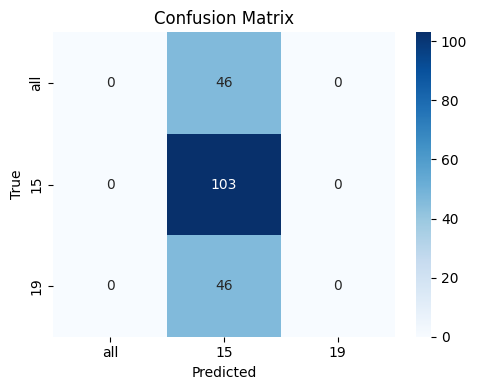

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

label_map = {"all": 0, "15": 1, "19": 2}
inv_label_map = {v: k for k, v in label_map.items()}  # 숫자를 다시 텍스트로 바꿀 때

test_dataset = FMRIDataset(test_df, label_map)
test_loader  = DataLoader(test_dataset, batch_size=1)

model = Text_Or_FMRI_Classifier(input_dim=769, hidden_dim=512, num_classes=3).cuda()
model.load_state_dict(torch.load("./experiments/experiment_only_text_3_best_model.pth"))
model.eval()

ce_loss = nn.CrossEntropyLoss()

total, correct = 0, 0
total_ce = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for fmri, text, label in test_loader:
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        pred_label = model(text)

        # Classification
        ce = ce_loss(pred_label, label)
        total_ce += ce.item()
        preds = pred_label.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

        # 리스트에 저장 (confusion matrix, report용)
        all_preds.append(preds.item())
        all_labels.append(label.item())

avg_ce = total_ce / len(test_loader)
acc = correct / total

print(f"Test Accuracy: {acc:.4f}")
print(f"Test CrossEntropy Loss: {avg_ce:.4f}")

# Confusion Matrix & Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["all", "15", "19"]))

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)
labels = ["all", "15", "19"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

1 - 0.00002
2 - 0.00001
3 - 0.000005
4 - 0.000001
5 - 0.0000001

## fmri only confusion metrix

Test Accuracy: 0.5282
Test CrossEntropy Loss: 1.0212

Confusion Matrix:
[[  0  46   0]
 [  0 103   0]
 [  0  46   0]]

Classification Report:
              precision    recall  f1-score   support

         all       0.00      0.00      0.00        46
          15       0.53      1.00      0.69       103
          19       0.00      0.00      0.00        46

    accuracy                           0.53       195
   macro avg       0.18      0.33      0.23       195
weighted avg       0.28      0.53      0.37       195



/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dhai/anaconda3/envs/whisper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

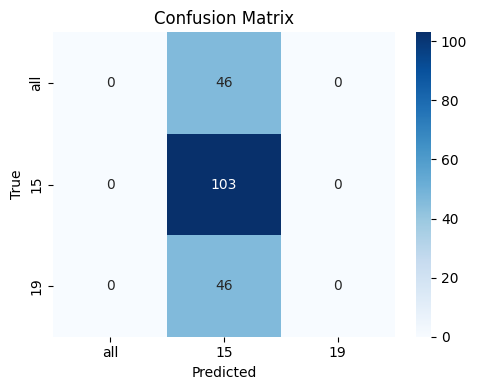

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

label_map = {"all": 0, "15": 1, "19": 2}
inv_label_map = {v: k for k, v in label_map.items()}  # 숫자를 다시 텍스트로 바꿀 때

test_dataset = FMRIDataset(test_df, label_map)
test_loader  = DataLoader(test_dataset, batch_size=1)

model = Text_Or_FMRI_Classifier(input_dim=288, hidden_dim=512, num_classes=3).cuda()
model.load_state_dict(torch.load("./experiments/experiment_only_fmri_2_best_model.pth"))
model.eval()

ce_loss = nn.CrossEntropyLoss()

total, correct = 0, 0
total_ce = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for fmri, text, label in test_loader:
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        pred_label = model(fmri)

        # Classification
        ce = ce_loss(pred_label, label)
        total_ce += ce.item()
        preds = pred_label.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

        # 리스트에 저장 (confusion matrix, report용)
        all_preds.append(preds.item())
        all_labels.append(label.item())

avg_ce = total_ce / len(test_loader)
acc = correct / total

print(f"Test Accuracy: {acc:.4f}")
print(f"Test CrossEntropy Loss: {avg_ce:.4f}")

# Confusion Matrix & Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["all", "15", "19"]))

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)
labels = ["all", "15", "19"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()